Upgrade pip installer to match python version

In [2]:
%pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Installing all necessary packages


In [3]:
%pip install sklearn
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install nflfastpy
%pip install statsmodels

%pip install nfl_data_py
%pip install seaborn
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [1]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier

In [2]:
pbp = nfl.import_pbp_data([2023])

2023 done.
Downcasting floats.


In [3]:
pbp.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,1.0,2023_01_ARI_WAS,2023091007,WAS,ARI,REG,1,None,None,None,...,,,0.0,0.0,NaN,NaN,NaN,None,None,None
1,39.0,2023_01_ARI_WAS,2023091007,WAS,ARI,REG,1,WAS,home,ARI,...,00-0035150;00-0037330;00-0036896;00-0033251;00...,00-0036403;00-0038635;00-0036614;00-0039149;00...,11.0,11.0,NaN,NaN,NaN,None,None,None
2,55.0,2023_01_ARI_WAS,2023091007,WAS,ARI,REG,1,WAS,home,ARI,...,00-0037746;00-0031095;00-0036334;00-0034445;00...,00-0035705;00-0035636;00-0036933;00-0036896;00...,11.0,11.0,NaN,NaN,NaN,None,None,None
3,77.0,2023_01_ARI_WAS,2023091007,WAS,ARI,REG,1,WAS,home,ARI,...,00-0037746;00-0031095;00-0036334;00-0034445;00...,00-0035705;00-0035636;00-0036933;00-0034375;00...,11.0,11.0,4.53,2.169,0.0,HITCH,ZONE_COVERAGE,COVER_3
4,102.0,2023_01_ARI_WAS,2023091007,WAS,ARI,REG,1,WAS,home,ARI,...,00-0031095;00-0036334;00-0034445;00-0031260;00...,00-0035705;00-0035636;00-0036933;00-0034375;00...,11.0,11.0,NaN,NaN,NaN,None,None,None


In [4]:
print(pbp.shape)
pbp_clean = pbp[(pbp['pass'] == 1) & (pbp['play_type'] != "no_play")]
print(pbp_clean.shape)

(44759, 390)
(19664, 390)


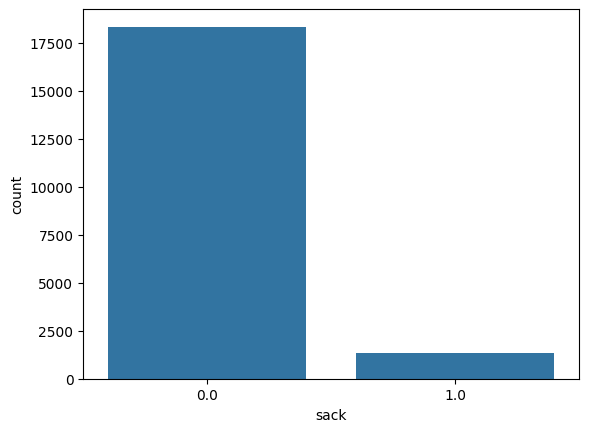

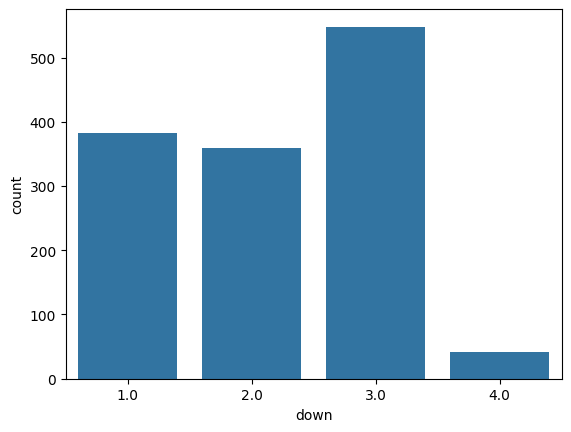

In [6]:
sns.countplot(x=pbp_clean["sack"])
plt.show()
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["down"])
plt.show()

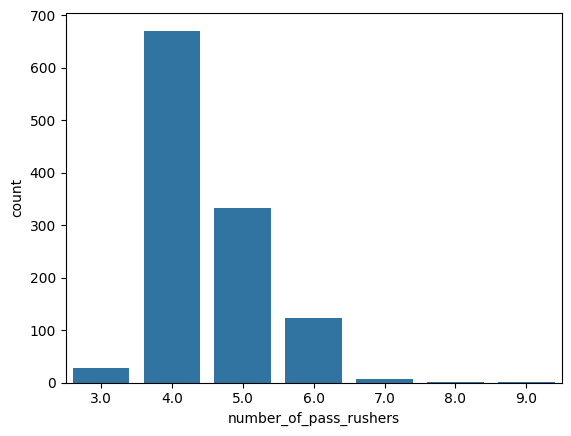

In [8]:
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["number_of_pass_rushers"])
plt.show()

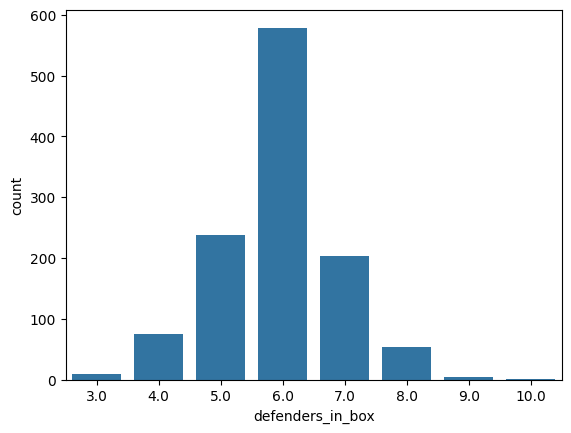

In [9]:
sacks = pbp_clean[(pbp_clean['sack'] == 1)]
sns.countplot(x=sacks["defenders_in_box"])
plt.show()

In [15]:
pbp_clean.loc[:, 'obvious_pass'] = np.where((pbp_clean['down'] == 3) & (pbp_clean['ydstogo'] >= 6), 1,0)

In [16]:
pre_df = pbp_clean[['game_id', 'play_id', 'season', 'name', 'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining',
                    'defenders_in_box', 'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack']]
df = pre_df.dropna()
df.isna().sum()

game_id                   0
play_id                   0
season                    0
name                      0
down                      0
ydstogo                   0
yardline_100              0
game_seconds_remaining    0
defenders_in_box          0
number_of_pass_rushers    0
xpass                     0
obvious_pass              0
sack                      0
dtype: int64

In [17]:
df.head()

,game_id,play_id,season,name,down,ydstogo,yardline_100,game_seconds_remaining,defenders_in_box,number_of_pass_rushers,xpass,obvious_pass,sack
3,2023_01_ARI_WAS,77.0,2023,S.Howell,2.0,7.0,72.0,3570.0,6.0,4.0,0.661106,0,0.0
5,2023_01_ARI_WAS,124.0,2023,S.Howell,1.0,10.0,64.0,3496.0,6.0,4.0,0.495536,0,0.0
6,2023_01_ARI_WAS,147.0,2023,S.Howell,2.0,10.0,64.0,3492.0,6.0,4.0,0.563005,0,0.0
7,2023_01_ARI_WAS,172.0,2023,S.Howell,1.0,10.0,52.0,3454.0,6.0,5.0,0.484261,0,0.0
8,2023_01_ARI_WAS,197.0,2023,S.Howell,2.0,9.0,51.0,3416.0,6.0,4.0,0.709240,0,0.0


In [19]:
df.loc[:, 'down'] = df['down'].astype('category')
df_no_ids = df.drop(columns = ['game_id', 'play_id', 'name', 'season'])
df_no_ids = pd.get_dummies(df_no_ids, columns = ['down'])

In [20]:
df_no_ids.columns

Index(['ydstogo', 'yardline_100', 'game_seconds_remaining', 'defenders_in_box',
       'number_of_pass_rushers', 'xpass', 'obvious_pass', 'sack', 'down_1.0',
       'down_2.0', 'down_3.0', 'down_4.0'],
      dtype='object')

In [21]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(df_no_ids, df_no_ids['sack']):
    strat_train_set = df_no_ids.iloc[train_index]
    strat_test_set = df_no_ids.iloc[test_index]

X_train = strat_train_set.drop(columns = ['sack'])
Y_train = strat_train_set['sack']
X_test = strat_test_set.drop(columns = ['sack'])
Y_test = strat_test_set['sack']

In [24]:
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train, Y_train)

LR_pred = pd.DataFrame(LR.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, LR_pred))


Brier Score:  0.06306268498665119


In [25]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

RF_pred = pd.DataFrame(RF.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, RF_pred))

Brier Score:  0.06850849926265236


In [26]:
XGB = XGBClassifier(objective="binary:logistic", random_state=42)
XGB.fit(X_train, Y_train)

XGB_pred = pd.DataFrame(XGB.predict_proba(X_test), columns = ['no_sack', 'sack'])[['sack']]

print('Brier Score: ', brier_score_loss(Y_test, XGB_pred))

Brier Score:  0.0676925227677576


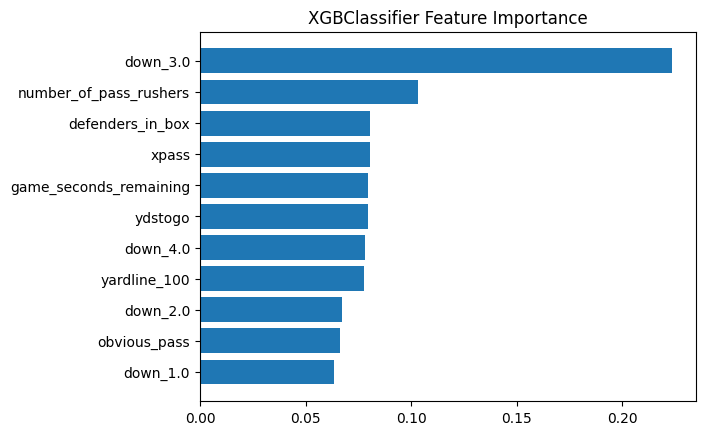

In [27]:
sorted_idx = XGB.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], XGB.feature_importances_[sorted_idx])
plt.title("XGBClassifier Feature Importance")
plt.show()